<a href="https://colab.research.google.com/github/PriyanshuChaubey/endoscopic-tumor-detection-dqn-cnn/blob/main/Stomach_cancer_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found classes: ['non-tumour', 'tumour']
Total images: 5484
Train images: 4387 Val images: 1097
Loading MobileNetV2 (frozen) for feature extraction...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features (train)...
Train features shape: (4387, 7, 7, 1280)
Extracting features (val)...
Val features shape: (1097, 7, 7, 1280)

Starting DQN training...
Episode 1/60  eps=0.995  reward=-216.0  val_acc=0.800  P=0.720 R=0.996 F1=0.836
Episode 2/60  eps=0.990  reward=-240.0  val_acc=0.905  P=0.848 R=0.991 F1=0.914
Episode 3/60  eps=0.985  reward=-244.0  val_acc=0.902  P=0.841 R=0.995 F1=0.911
Episode 4/60  eps=0.980  reward=-254.0  val_acc=0.896  P=0.835 R=0.993 F1=0.907
Episode 5/60  eps=0.975  reward=-186.0  val_acc=0.920  P=0.870 R=0.991 F1=0.926
Episode 6/60  eps=0.970  reward=-188.0  val_acc=0.917  P=0.864 R=0.993 F1=0.924
Episode 7/60  eps=0.966  r

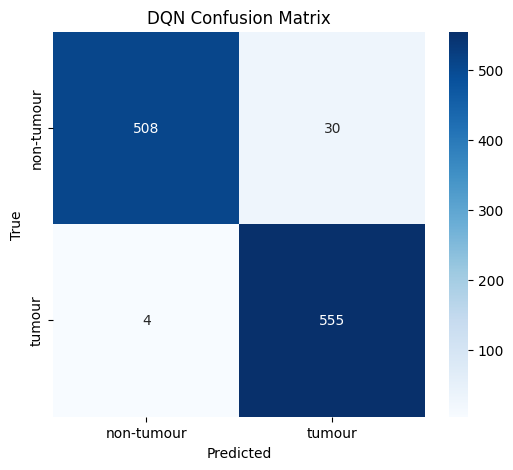

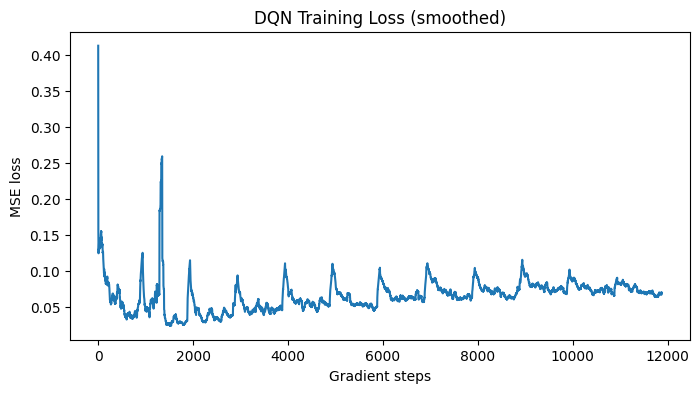

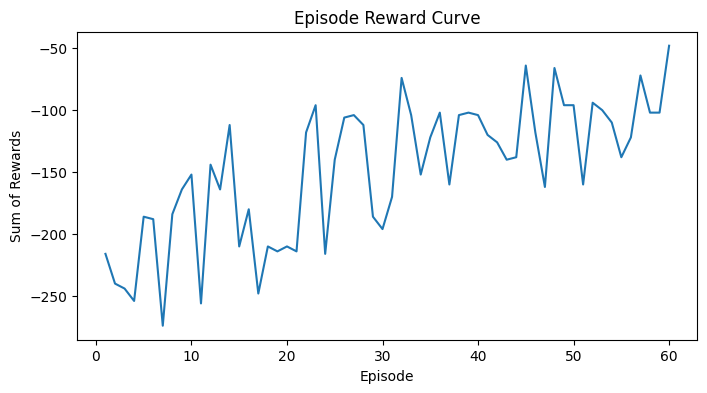

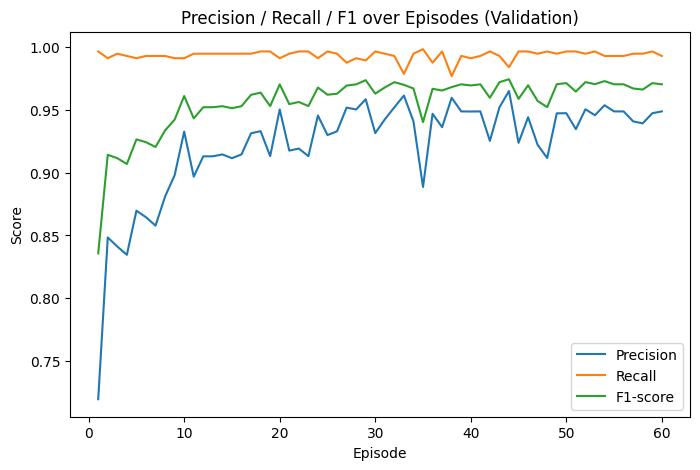

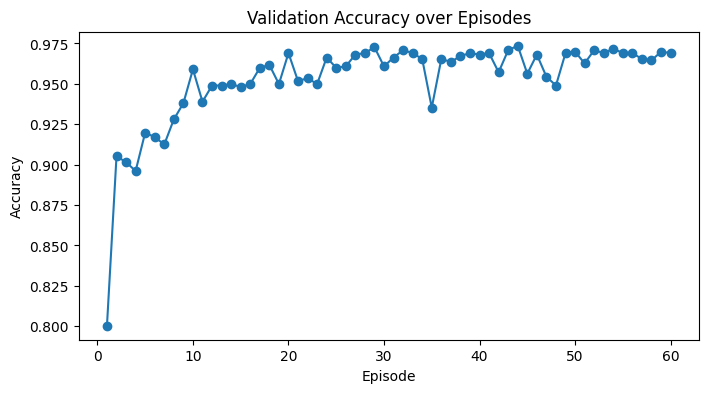

In [ ]:
# Advanced DQN + CNN Feature extractor for Tumour / Non-tumour classification
# Colab-ready. Requires tensorflow, sklearn, matplotlib, seaborn, numpy.
# Mount Drive in Colab:
from google.colab import drive
drive.mount('/content/drive')

import os, random, math, time
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# -------------------------
# CONFIG / HYPERPARAMS
# -------------------------
DATA_DIR = "/content/drive/MyDrive/stomach_cancer_dataset"   # <-- set this to your folder
IMG_SIZE = (224, 224)
FEATURE_DIM = 1280   # MobileNetV2's final conv output channel count when include_top=False
MAX_TRAIN_SAMPLES = None   # set None to use all
MAX_VAL_SAMPLES = None

# DQN hyperparams
STATE_DIM = (7, 7, 1280)  # feature "map" shape produced by MobileNetV2 include_top=False (we'll flatten later)
FLATTENED_DIM = 7*7*1280
ACTION_SIZE = 2            # 0: non-tumour, 1: tumour
REPLAY_CAPACITY = 20000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 1e-4
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 5    # update target network every N episodes
NUM_EPISODES = 60         # increase if you have more compute
STEPS_PER_EPISODE = 200   # how many samples per episode (you can use all or subset)
TRAIN_STEPS_PER_EPISODE = 10  # how many replay training iterations per episode

# Reward shaping (medical priority)
REWARD_CORRECT = 1.0
REWARD_INCORRECT = -1.0
# Make false negative (miss tumor) worse:
PENALTY_FALSE_NEG = -5.0  # predicted non-tumour while true tumour
PENALTY_FALSE_POS = -1.0  # predicted tumour while true non-tumour

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# -------------------------
# UTIL: gather image file paths and labels
# -------------------------
def gather_paths_labels(data_dir):
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    paths, labels = [], []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(cls_dir, fname))
                labels.append(idx)
    return paths, labels, classes

paths, labels, class_names = gather_paths_labels(DATA_DIR)
print("Found classes:", class_names)
print("Total images:", len(paths))
if len(paths) == 0:
    raise SystemExit("No images found. Check DATA_DIR path.")

# -------------------------
# Split into train / val
# -------------------------
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, stratify=labels, random_state=SEED)

if MAX_TRAIN_SAMPLES:
    train_paths = train_paths[:MAX_TRAIN_SAMPLES]; train_labels = train_labels[:MAX_TRAIN_SAMPLES]
if MAX_VAL_SAMPLES:
    val_paths = val_paths[:MAX_VAL_SAMPLES]; val_labels = val_labels[:MAX_VAL_SAMPLES]

print("Train images:", len(train_paths), "Val images:", len(val_paths))

# -------------------------
# Feature extractor (MobileNetV2)
# -------------------------
print("Loading MobileNetV2 (frozen) for feature extraction...")
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False
feature_model = Model(inputs=base.input, outputs=base.output)  # outputs shape: (7,7,1280)

def load_and_preprocess(path):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)  # preprocess consistent with MobileNetV2
    return arr

# -------------------------
# Extract features for all train/val images (done once)
# -------------------------
def extract_features_list(paths_list, batch=32):
    feats = []
    for i in range(0, len(paths_list), batch):
        batch_paths = paths_list[i:i+batch]
        batch_imgs = np.array([load_and_preprocess(p) for p in batch_paths])
        batch_feats = feature_model.predict(batch_imgs, verbose=0)  # shape (b,7,7,1280)
        feats.append(batch_feats)
    feats = np.vstack(feats)
    return feats

print("Extracting features (train)...")
train_feats = extract_features_list(train_paths, batch=32)
print("Train features shape:", train_feats.shape)
print("Extracting features (val)...")
val_feats = extract_features_list(val_paths, batch=32)
print("Val features shape:", val_feats.shape)

# Flatten states for DQN input
train_states = train_feats.reshape((train_feats.shape[0], -1)).astype(np.float32)
val_states = val_feats.reshape((val_feats.shape[0], -1)).astype(np.float32)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# -------------------------
# Replay Buffer
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        states, actions, rewards, next_states = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)
    def __len__(self):
        return len(self.buffer)

# -------------------------
# DQN agent with target network
# -------------------------
def build_q_network(input_dim, action_size, lr=LR):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

input_dim = train_states.shape[1]
q_net = build_q_network(input_dim, ACTION_SIZE)
target_q = build_q_network(input_dim, ACTION_SIZE)
target_q.set_weights(q_net.get_weights())

replay = ReplayBuffer(REPLAY_CAPACITY)
epsilon = EPS_START

loss_history = []
reward_history = []
val_acc_history = []
precision_history = []
recall_history = []
f1_history = []
episode_steps = []

# -------------------------
# Helper: get reward with shaping
# -------------------------
def shaped_reward(pred_action, true_label):
    if pred_action == true_label:
        # correct
        return REWARD_CORRECT
    else:
        # incorrect - check FN/FP
        if pred_action == 0 and true_label == 1:
            # false negative: predicted non-tumour but true tumour -> heavy penalty
            return PENALTY_FALSE_NEG
        elif pred_action == 1 and true_label == 0:
            # false positive: predicted tumour but true non-tumour
            return PENALTY_FALSE_POS
        else:
            return REWARD_INCORRECT

# -------------------------
# DQN training loop
# -------------------------
print("\nStarting DQN training...")
for ep in range(1, NUM_EPISODES+1):
    ep_reward = 0.0
    # sample indices (we will iterate STEPS_PER_EPISODE random samples)
    idxs = random.choices(range(len(train_states)), k=STEPS_PER_EPISODE)
    for step_idx, idx in enumerate(idxs):
        state = train_states[idx:idx+1]   # shape (1, input_dim)
        true_label = int(train_labels[idx])

        # ε-greedy action selection
        if random.random() < epsilon:
            action = random.randrange(ACTION_SIZE)
        else:
            q_vals = q_net.predict(state, verbose=0)[0]
            action = int(np.argmax(q_vals))

        # reward & next state (here next_state we can use same or next sample; we use next sample in sequence)
        next_idx = random.randrange(len(train_states))
        next_state = train_states[next_idx:next_idx+1]

        r = shaped_reward(action, true_label)
        ep_reward += r

        replay.push(state.flatten(), action, r, next_state.flatten())

        # train step: sample and update
        if len(replay) >= BATCH_SIZE:
            s_batch, a_batch, r_batch, ns_batch = replay.sample(BATCH_SIZE)
            # predict Q(s) and Q(next_s)
            q_s = q_net.predict(s_batch, verbose=0)
            q_next = target_q.predict(ns_batch, verbose=0)
            # prepare targets
            q_targets = q_s.copy()
            for i in range(len(s_batch)):
                q_targets[i, a_batch[i]] = r_batch[i] + GAMMA * np.max(q_next[i])
            hist = q_net.fit(s_batch, q_targets, epochs=1, verbose=0)
            loss_history.append(hist.history['loss'][0])

    # decay epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    reward_history.append(ep_reward)

    # update target network periodically
    if ep % TARGET_UPDATE_FREQ == 0:
        target_q.set_weights(q_net.get_weights())

    # periodic evaluation on validation set
    if ep % 1 == 0:
        # evaluate DQN on entire val set
        q_preds = q_net.predict(val_states, verbose=0)
        pred_actions = np.argmax(q_preds, axis=1)
        val_acc = accuracy_score(val_labels, pred_actions)
        precision, recall, f1, _ = precision_recall_fscore_support(val_labels, pred_actions, average='binary', zero_division=0)
        val_acc_history.append(val_acc)
        precision_history.append(precision)
        recall_history.append(recall)
        f1_history.append(f1)
        episode_steps.append(ep)
        print(f"Episode {ep}/{NUM_EPISODES}  eps={epsilon:.3f}  reward={ep_reward:.1f}  val_acc={val_acc:.3f}  P={precision:.3f} R={recall:.3f} F1={f1:.3f}")

print("DQN training finished.")

# -------------------------
# Final evaluation & plots
# -------------------------
# Final predictions on val set
q_vals_final = q_net.predict(val_states, verbose=0)
y_pred = np.argmax(q_vals_final, axis=1)
y_true = val_labels

print("\nFinal Validation Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("DQN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot DQN loss (smoothed)
plt.figure(figsize=(8,4))
if len(loss_history) > 0:
    loss_arr = np.array(loss_history)
    window = max(1, len(loss_arr)//200)
    loss_smooth = np.convolve(loss_arr, np.ones(window)/window, mode='valid')
    plt.plot(loss_smooth)
    plt.title("DQN Training Loss (smoothed)")
    plt.xlabel("Gradient steps")
    plt.ylabel("MSE loss")
else:
    plt.text(0.5,0.5,"No loss history",ha='center')
plt.show()

# Reward curve
plt.figure(figsize=(8,4))
plt.plot(episode_steps, reward_history[:len(episode_steps)])
plt.title("Episode Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Sum of Rewards")
plt.show()

# Precision/Recall/F1 curves across episodes
plt.figure(figsize=(8,5))
plt.plot(episode_steps, precision_history, label='Precision')
plt.plot(episode_steps, recall_history, label='Recall')
plt.plot(episode_steps, f1_history, label='F1-score')
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 over Episodes (Validation)")
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(8,4))
plt.plot(episode_steps, val_acc_history, marker='o')
plt.title("Validation Accuracy over Episodes")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.show()